In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
from skimage.feature import SIFT, match_descriptors, plot_matches
from skimage.color import rgb2gray
from skimage.io import imread

In [4]:
threshold=0.75

In [5]:
def getCorners(img,numCorners):
    cImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(cImg, numCorners, 0.01, 10)
    return corners.reshape(-1, 2).astype(int)

In [6]:
def getFeatures(img, corners):
    # Calculate gradient using Sobel operator
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)

    # Convert gradients to magnitude and angle
    mag, ang = cv2.cartToPolar(gx, gy)  # Convert gradients to magnitude and angle

    # Quantize angles into 16 bins
    bins = np.int32(16 * ang / (2 * np.pi))

    # Initialize histogram matrix
    hist = np.zeros((corners.shape[0], 16))

    # Compute histograms for each corner
    for i, (x, y) in enumerate(corners):
        # Extract the bin and magnitude blocks around the corner
        bin_block = bins[y-8:y+8, x-8:x+8]
        mag_block = mag[y-8:y+8, x-8:x+8]

        # Compute histogram for the block using bin counts weighted by magnitudes
        hist[i] = np.bincount(bin_block.ravel(), weights=mag_block.ravel(), minlength=16)

    # Normalize histograms to unit length
    hist /= (np.linalg.norm(hist, axis=1, keepdims=True) + 1e-5)

    return hist


In [7]:
def getMatches(feat1, feat2):
    # Compute the dot product of feature vectors of feat1 and feat2
    scores = np.dot(feat1, feat2.T)

    # Find matches where the dot product is above the specified threshold
    matches = np.where(scores > threshold)

    # Return the list of matching indices
    return list(zip(matches[0], matches[1]))


In [8]:
def display_image_with_corners(image, corners, title="Image"):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Plot the corners on the image
    plt.scatter(corners[:, 0], corners[:, 1], s=40, marker='x', color='black')
    plt.title(title)
    plt.show()


In [9]:
def display_matches(img1, img2, corners1, corners2, matches):
    # Get the dimensions of the input images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Create a new blank image to display both images side by side
    new_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    new_img[:h1, :w1, :] = img1  # Place the first image on the left side
    new_img[:h2, w1:w1 + w2, :] = img2  # Place the second image on the right side

    #Plot
    plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
    for i1, i2 in matches:
        x1, y1 = corners1[i1]
        x2, y2 = corners2[i2]
        plt.plot([x1, x2 + w1], [y1, y2], 'r')
        plt.scatter([x1, x2 + w1], [y1, y2], s=40, marker='x', color='black')
    plt.show()




In [10]:
def load_and_check_image(image_path, convert_to_gray=False):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Failed to load image at path: {image_path}")

    if convert_to_gray and image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    return image

In [11]:
def plot_corners(image_name, corners_x, corners_y):
    plt.figure(figsize=(8, 6))
    plt.plot(corners_x, corners_y, 'ro')
    plt.title(f'Corners of {image_name}')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.show()

In [12]:
image_path = "/content/drive/MyDrive/ACV/Assignment-1/TEST_IMAGES/"
# image_path="./UCR/Q3/ACV/Assignment-1/TEST_IMAGES/"

In [13]:
# load the original and transformed images

orig_I = cv2.imread(f"{image_path}blocks.png")
trf1_I =cv2.imread(f"{image_path}blocks_tform1.png")
trf2_I =cv2.imread(f"{image_path}blocks_tform2.png")

/content/drive/MyDrive/ACV/Assignment-1/TEST_IMAGES/blocks.png


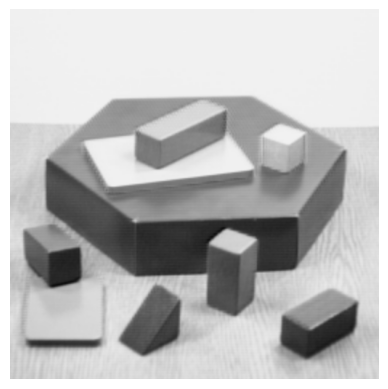

In [14]:
orig_I = cv2.imread(image_path + 'blocks.png')
print(image_path + 'blocks.png')
plt.imshow(cv2.cvtColor(orig_I, cv2.IMREAD_GRAYSCALE))
plt.axis('off')
plt.show()

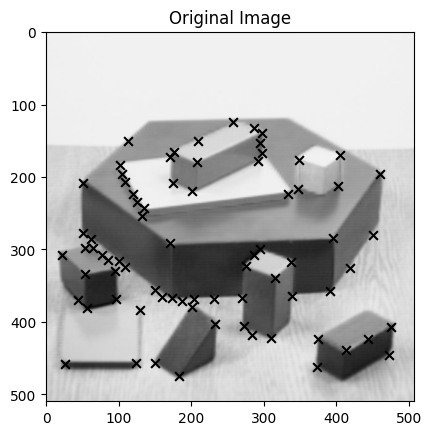

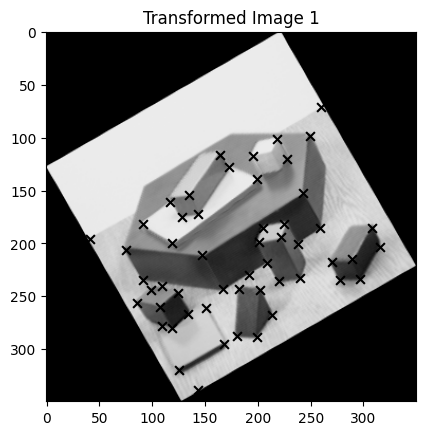

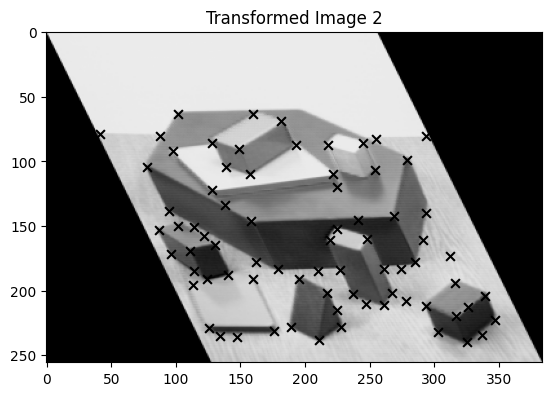

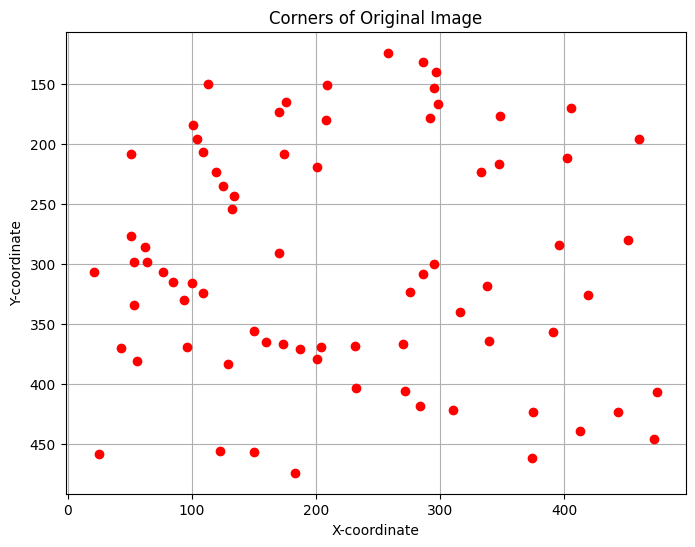

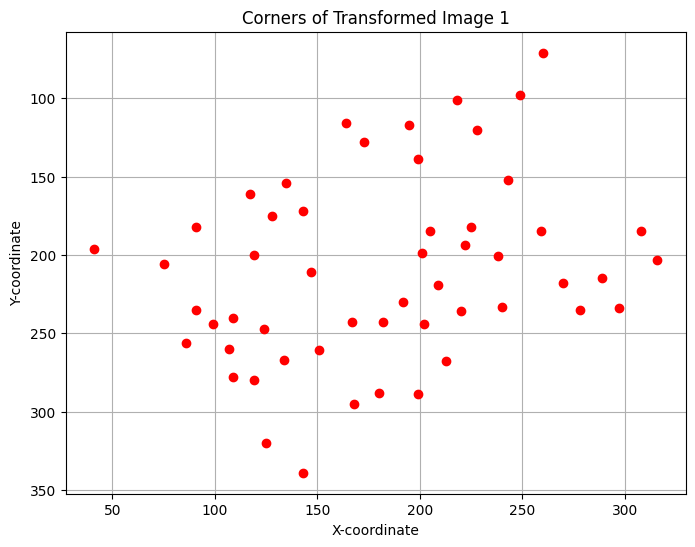

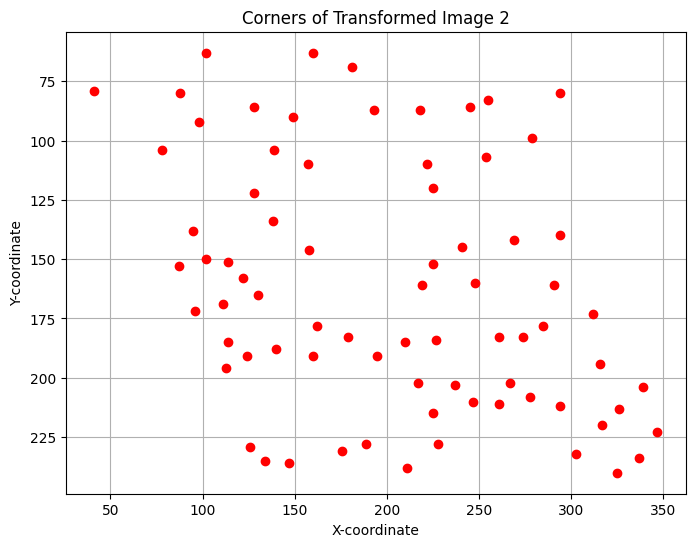

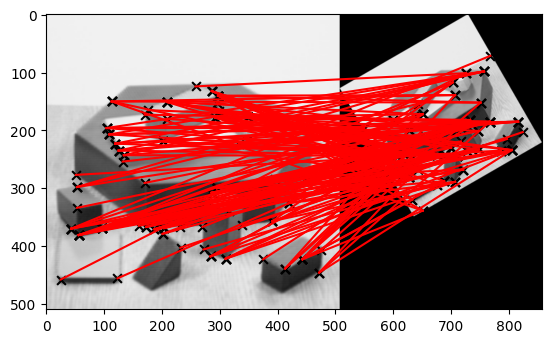

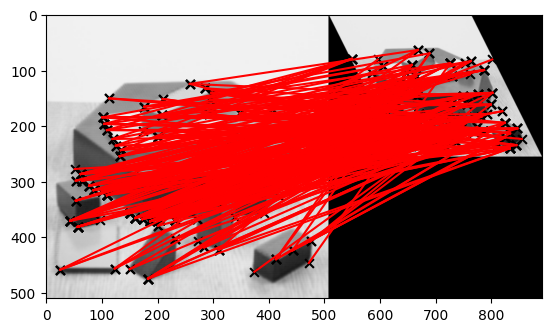

In [15]:

## plot the original and transformed images

# get the corners of each image
numCorners=75
corners_orig_I = getCorners(orig_I,numCorners)
corners_trf1_I = getCorners(trf1_I,numCorners)
corners_trf2_I = getCorners(trf2_I,numCorners)

## plot the detected corners of the original and transformed images
display_image_with_corners(orig_I, corners_orig_I, "Original Image")
display_image_with_corners(trf1_I, corners_trf1_I, "Transformed Image 1")
display_image_with_corners(trf2_I, corners_trf2_I, "Transformed Image 2")

# compute HoG features of all images using the corner coordinate information
feat_orig_I = getFeatures(orig_I,corners_orig_I)
feat_trf1_I = getFeatures(trf1_I,corners_trf1_I)
feat_trf2_I = getFeatures(trf2_I,corners_trf2_I)

## plot the coordinates corners of all the images
orig_x, orig_y = corners_orig_I[:, 0], corners_orig_I[:, 1]
trf1_x, trf1_y = corners_trf1_I[:, 0], corners_trf1_I[:, 1]
trf2_x, trf2_y = corners_trf2_I[:, 0], corners_trf2_I[:, 1]

# Plot corners for each image
plot_corners('Original Image', corners_orig_I[:, 0], corners_orig_I[:, 1])
plot_corners('Transformed Image 1', corners_trf1_I[:, 0], corners_trf1_I[:, 1])
plot_corners('Transformed Image 2', corners_trf2_I[:, 0], corners_trf2_I[:, 1])

# match features of original and each transformed image
matches1 = getMatches(feat_orig_I,feat_trf1_I)
matches2 = getMatches(feat_orig_I,feat_trf2_I)

## plot the matches
display_matches(orig_I, trf1_I, corners_orig_I, corners_trf1_I, matches1)
display_matches(orig_I, trf2_I, corners_orig_I, corners_trf2_I, matches2)


In [1]:
def plot_sift_matches(image1, image2, keypoints1, keypoints2, matches):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 15))
    plot_matches(ax, image1, image2, keypoints1, keypoints2, matches)
    ax.axis('off')
    ax.set_title('Matched SIFT Features')
    plt.show()

In [2]:
def detect_and_extract_keypoints(image, sift):
    sift.detect_and_extract(image)
    return sift.keypoints, sift.descriptors

In [16]:
def match_keypoints(keypoints1, descriptors1, keypoints2, descriptors2):
    return match_descriptors(descriptors1, descriptors2, cross_check=True)


In [17]:
def extract_and_match_sift_features(image1, image2):
    # Convert images to grayscale
    image1_gray = rgb2gray(image1)
    image2_gray = rgb2gray(image2)

    # Initialize SIFT object
    sift = SIFT()

    # Detect and extract keypoints and descriptors for first image
    keypoints1, descriptors1 = detect_and_extract_keypoints(image1_gray, sift)

    # Detect and extract keypoints and descriptors for second image
    keypoints2, descriptors2 = detect_and_extract_keypoints(image2_gray, sift)

    # Match keypoints between two images
    matches = match_keypoints(keypoints1, descriptors1, keypoints2, descriptors2)

    # Plot SIFT feature matches
    plot_sift_matches(image1_gray, image2_gray, keypoints1, keypoints2, matches)

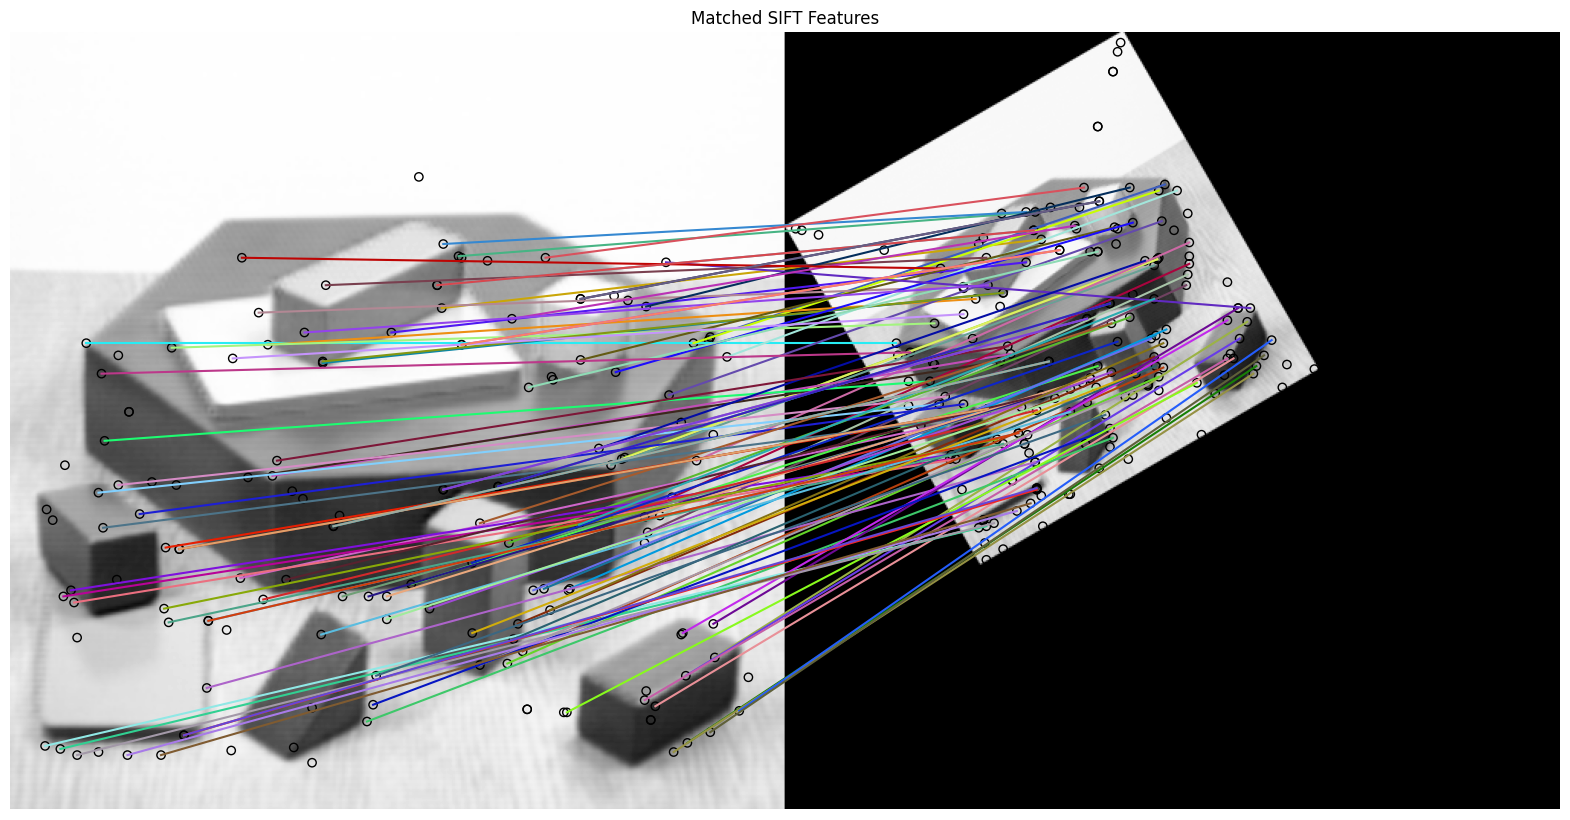

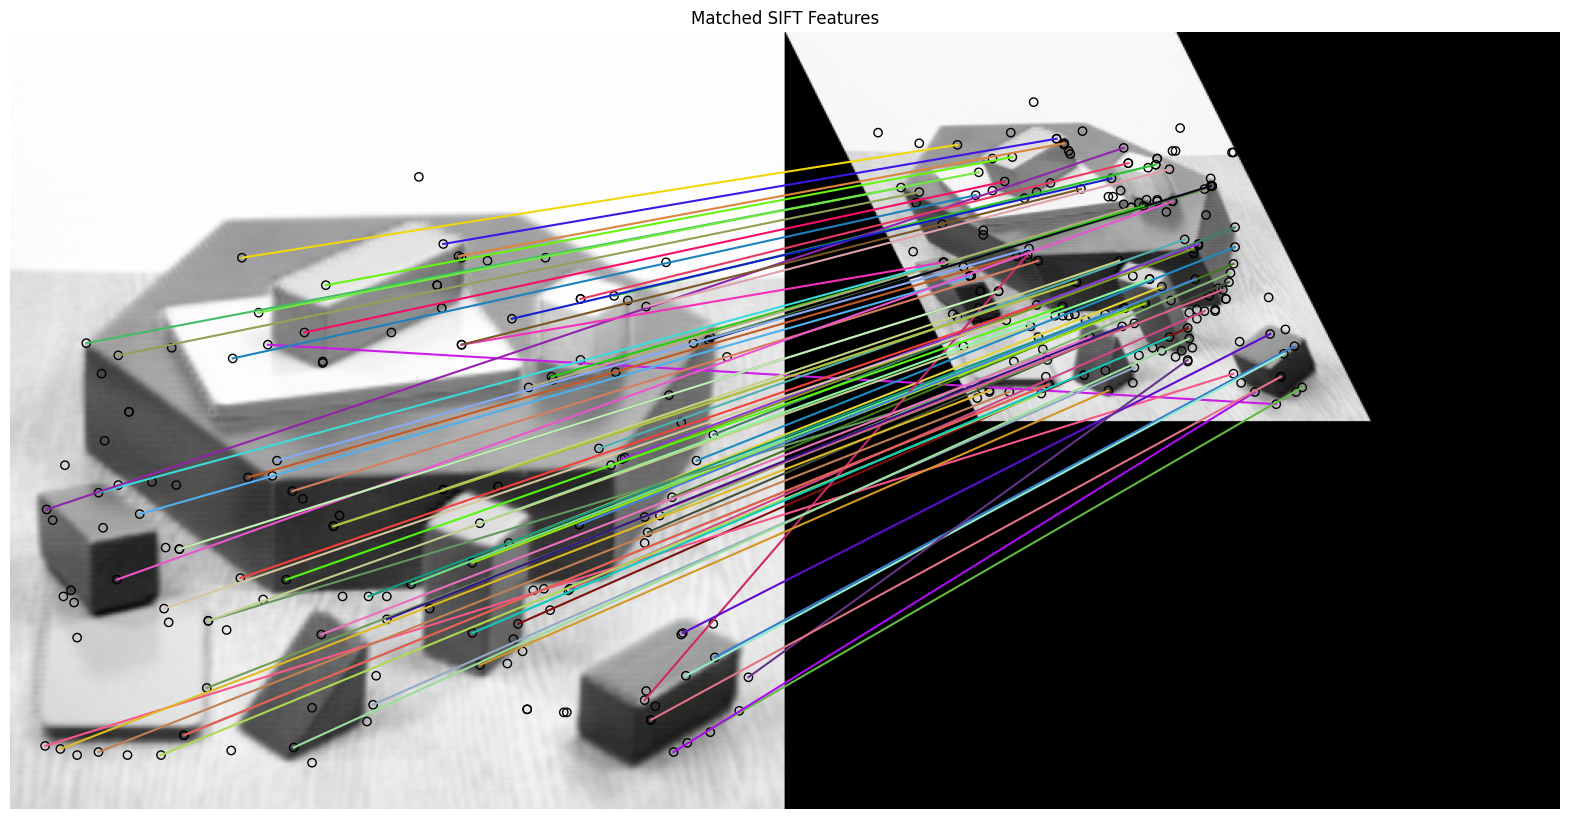

In [18]:

extract_and_match_sift_features(orig_I, trf1_I)
extract_and_match_sift_features(orig_I, trf2_I)
